# Imports

In [1]:
# Imports
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, plot_confusion_matrix, auc, roc_curve, roc_auc_score, average_precision_score

from sklearn.neighbors import NearestNeighbors

# from imblearn.over_sampling import RandomOverSampler, SMOTE

# measuring fairness
from fairlearn.metrics import (
    count,
    demographic_parity_difference,
    equalized_odds_difference,
    false_positive_rate,
    false_negative_rate,
    MetricFrame,
    make_derived_metric,
    selection_rate,  
)
from sklearn.metrics import precision_score
from sklearn.calibration import calibration_curve

import matplotlib.pyplot as plt

from random import sample
# from random import choice

import warnings
warnings.filterwarnings("ignore")

# COMPAS data cleaning

In [2]:
compas_raw = pd.read_csv("compas-scores-two-years.csv")

In [3]:
compas_raw

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7209,10996,steven butler,steven,butler,2013-11-23,Male,1992-07-17,23,Less than 25,African-American,...,5,Medium,2013-11-23,2013-11-22,2013-11-24,0,1,860,0,0
7210,10997,malcolm simmons,malcolm,simmons,2014-02-01,Male,1993-03-25,23,Less than 25,African-American,...,5,Medium,2014-02-01,2014-01-31,2014-02-02,0,1,790,0,0
7211,10999,winston gregory,winston,gregory,2014-01-14,Male,1958-10-01,57,Greater than 45,Other,...,1,Low,2014-01-14,2014-01-13,2014-01-14,0,0,808,0,0
7212,11000,farrah jean,farrah,jean,2014-03-09,Female,1982-11-17,33,25 - 45,African-American,...,2,Low,2014-03-09,2014-03-08,2014-03-09,3,0,754,0,0


In [4]:
compas_raw.isna().sum()

id                            0
name                          0
first                         0
last                          0
compas_screening_date         0
sex                           0
dob                           0
age                           0
age_cat                       0
race                          0
juv_fel_count                 0
decile_score                  0
juv_misd_count                0
juv_other_count               0
priors_count                  0
days_b_screening_arrest     307
c_jail_in                   307
c_jail_out                  307
c_case_number                22
c_offense_date             1159
c_arrest_date              6077
c_days_from_compas           22
c_charge_degree               0
c_charge_desc                29
is_recid                      0
r_case_number              3743
r_charge_degree            3743
r_days_from_arrest         4898
r_offense_date             3743
r_charge_desc              3801
r_jail_in                  4898
r_jail_o

In [5]:
# filter similar to propublica
compas_drop = compas_raw[
    (compas_raw["days_b_screening_arrest"] <= 30)
    & (compas_raw["days_b_screening_arrest"] >= -30)
    & (compas_raw["is_recid"] != -1)
    & (compas_raw["c_charge_degree"] != "O")
    & (compas_raw["score_text"] != "N/A")
]

compas_drop = compas_drop[["sex", "age", "race", "priors_count", 'c_charge_degree', "two_year_recid"]]

compas_drop.head()

,sex,age,race,priors_count,c_charge_degree,two_year_recid
0,Male,69,Other,0,F,0
1,Male,34,African-American,0,F,1
2,Male,24,African-American,4,F,1
5,Male,44,Other,0,M,0
6,Male,41,Caucasian,14,F,1


In [6]:
compas_drop['race'].unique()

array(['Other', 'African-American', 'Caucasian', 'Hispanic', 'Asian',
       'Native American'], dtype=object)

In [7]:
compas_bin = compas_drop[(compas_drop['race'] == 'African-American') | (compas_drop['race'] == 'Caucasian')]

In [8]:
compas_bin.reset_index(drop=True)

,sex,age,race,priors_count,c_charge_degree,two_year_recid
0,Male,34,African-American,0,F,1
1,Male,24,African-American,4,F,1
2,Male,41,Caucasian,14,F,1
3,Female,39,Caucasian,0,M,0
4,Male,27,Caucasian,0,F,0
...,...,...,...,...,...,...
5273,Male,30,African-American,0,M,1
5274,Male,20,African-American,0,F,0
5275,Male,23,African-American,0,F,0
5276,Male,23,African-American,0,F,0


In [9]:
compas_bin['two_year_recid'].value_counts()

0    2795
1    2483
Name: two_year_recid, dtype: int64

In [10]:
compas_bin.value_counts(['race', 'two_year_recid']).to_frame()

0
race             two_year_recid      
African-American 1               1661
                 0               1514
Caucasian        0               1281
                 1                822

In [11]:
compas = compas_bin

In [12]:
compas['sex'] = (compas['sex'] == 'Male').astype(int) # Male = 1, Female = 0
compas['race'] = (compas['race'] == 'Caucasian').astype(int) # Caucasian = 1, African-American = 0
compas['c_charge_degree'] = (compas['c_charge_degree'] == 'F').astype(int) # F = 1, M = 0
compas.nunique() # Check if there are any other values

sex                 2
age                62
race                2
priors_count       36
c_charge_degree     2
two_year_recid      2
dtype: int64

## Base rate

In [13]:
def base_rate_compas(data):
    # by choosing y_pred to be ground truth instead of predictions, we can easily compute the base rate in the data
    mf = MetricFrame(
        metrics={"base rate": selection_rate},
        y_true=data["two_year_recid"],  # y_true is ignored
        y_pred=data["two_year_recid"],
        sensitive_features=data["race"],
    )
    display(mf.by_group)

    # summarize demographic parity as the max difference between groups
    print("base rate diff: %.2f" % mf.difference(method="between_groups"))
    
    
    crtr = data['two_year_recid'].sum() / len(data) # class rate
    print('Class rate: %.4f' % crtr)
    
    grtr = data['race'].sum() / len(data) # group rate
    print('Group rate: %.4f' % grtr)

In [14]:
base_rate_compas(compas)

,base rate
race,
0,0.52315
1,0.39087


base rate diff: 0.13
Class rate: 0.4704
Group rate: 0.3984


# Data sets

In [15]:
# Train test split
rs = 0 # Random State

trainset, testset = train_test_split(compas, test_size=0.25, random_state=rs)

In [16]:
def get_max():
    m = 0
    for s in (0, 1):
        for c in (0, 1):
            data_temp = trainset[(trainset['race'] == s) & (trainset['two_year_recid'] == c)]
            if m < len(data_temp):
                m = len(data_temp)
    return m

In [17]:
base_rate_compas(testset)

,base rate
race,
0,0.496847
1,0.383302


base rate diff: 0.11
Class rate: 0.4515
Group rate: 0.3992


## Uncorrected data set

In [18]:
data_uncorrected = trainset

In [19]:
base_rate_compas(data_uncorrected)

,base rate
race,
0,0.531906
1,0.393401


base rate diff: 0.14
Class rate: 0.4768
Group rate: 0.3982


## Naive oversampling

In [20]:
empty = trainset[trainset['two_year_recid'] == 3]
print(empty)

Empty DataFrame
Columns: [sex, age, race, priors_count, c_charge_degree, two_year_recid]
Index: []


In [21]:
data_naive_oversampling = empty

m = get_max()

for s in (0, 1):
    for c in (0, 1):
        data_temp = trainset[(trainset['race'] == s) & (trainset['two_year_recid'] == c)]
        while len(data_temp) < m - 100:
            data_temp = data_temp.append(data_temp.sample(100))
        while len(data_temp) < m:
            data_temp = data_temp.append(data_temp.sample())
        data_naive_oversampling = data_naive_oversampling.append(data_temp)
        
data_naive_oversampling = data_naive_oversampling.reset_index(drop=True)

In [22]:
base_rate_compas(data_naive_oversampling)

,base rate
race,
0,0.5
1,0.5


base rate diff: 0.00
Class rate: 0.5000
Group rate: 0.5000


## Uniform Sampling

In [23]:
data_uniform_sampling = empty

for s in (0, 1):
    for c in (0, 1):
        data_temp = trainset[(trainset['race'] == s) & (trainset['two_year_recid'] == c)]
        w = (len(trainset[(trainset['race'] == s)]) * len(trainset[(trainset['two_year_recid'] == c)])) / (len(trainset) * len(data_temp))
        size = int(w * len(data_temp))
        new = data_temp.sample()
        while len(new) < size - 100:
            new = new.append(data_temp.sample(100))
        while len(new) < size:
            new = new.append(data_temp.sample())
        # print(len(new))
        data_uniform_sampling = data_uniform_sampling.append(new)
        
data_uniform_sampling = data_uniform_sampling.reset_index(drop=True)

In [24]:
base_rate_compas(data_uniform_sampling)

,base rate
race,
0,0.47669
1,0.476825


base rate diff: 0.00
Class rate: 0.4767
Group rate: 0.3981


## Fair-SMOTE

In [25]:
data_fair_smote = empty

m = get_max()

cr, f = 0.8, 0.8
probab = [cr+(1-cr)/3, (1-cr)/3, (1-cr)/3]
        
def get_neighbors(data, nbrs):
    parent = data.sample()
    arr1 = nbrs.kneighbors(parent, return_distance=False)[0]
    arr2 = [a for a in arr1 if (a != parent.index)]

    neigh1 = data.iloc[arr2[0]]
    neigh2 = data.iloc[arr2[1]]
    return parent, neigh1, neigh2
            
for s in (0, 1):
    for c in (0, 1):
        data_temp = trainset[(trainset['race'] == s) & (trainset['two_year_recid'] == c)].reset_index(drop=True)
        
        knn = NearestNeighbors(n_neighbors=3).fit(data_temp)

        while len(data_temp) < m:
            p, n1, n2 = get_neighbors(data_temp, knn)
    
            new_row = data_temp[data_temp['two_year_recid'] == 3]
            
            for col in p.columns:
                if col in ['age', 'prior_counts']:
                    # print(int(p[col] + f * (n1[col] - n2[col])))
                    # print(int(p[col]),int(n1[col]), int(n2[col]))
                    val = int(p[col] + f * (n1[col] - n2[col]))
                    arr = [val, p[col]]
                    pr = [cr, (1 - cr)]
                    new_row[col] = [np.random.choice(a=arr, p=pr)]
                else:
                    arr = [int(p[col]), int(n1[col]), int(n2[col])]
                    new_row[col] = [np.random.choice(a=arr, p=probab)]
            data_temp = data_temp.append(new_row)
            # print('A row to append:\n', new_row, '\n')
            
        data_fair_smote = data_fair_smote.append(data_temp)

data_fair_smote = data_fair_smote.reset_index(drop=True)

In [26]:
base_rate_compas(data_fair_smote)

,base rate
race,
0,0.5
1,0.5


base rate diff: 0.00
Class rate: 0.5000
Group rate: 0.5000


# Model training

## Test set

In [27]:
y_test = testset['two_year_recid']
X_test = testset.drop(columns=['two_year_recid'])

## Functions

In [28]:
def lr_metrics(traindataset):
    '''
    Logistic regression model metrics
    '''
    
    y_train = traindataset['two_year_recid']
    X_train = traindataset.drop(columns=['two_year_recid'])
    
    modelRG = RidgeClassifier(random_state=rs) # Logistic Regression Ridge
    
    modelRG.fit(X_train, y_train)
    
    y_pred = modelRG.predict(X_test)
    y_pp = modelRG.decision_function(X_test)
    
    cm = confusion_matrix(y_test, y_pred)

    cr = classification_report(y_test, y_pred)
    print(cr)
    dis = ConfusionMatrixDisplay(cm)
    dis.plot(cmap='cividis', values_format='.0f')
    
    auc = roc_auc_score(y_test, y_pred)
    print('AUC score = %.2f' % auc)

    # compute metrics by group
    mf = MetricFrame(
        metrics={"selection rate (compas)": selection_rate},
        y_true=y_test,  # is ignored
        y_pred=y_pred,
        sensitive_features=X_test["race"],
    )

    # print results
    display(mf.by_group)
    print("Overall selection rate: %.2f" % mf.overall)

    # compute demographic parity as the max difference between groups
    print("demographic parity difference: %.2f" % mf.difference(method="between_groups"))

    # compute metrics
    mf = MetricFrame(
        metrics={
            "false positive rate": false_positive_rate,
            "false negative rate": false_negative_rate,
        },
        y_true=y_test,
        y_pred=y_pred,
        sensitive_features=X_test[["race"]],
    )
    display(mf.by_group)

    # print differences
    for i in mf.difference("between_groups").iteritems():
        print("%s diff: %.2f" % i)

    # alternatively: summarize equalized odds in one metric (which is the max of fpr diff and fnr diff)
    dpd = equalized_odds_difference(
        y_test,
        y_pred,
        sensitive_features=X_test["race"],
        method="between_groups",
    )
    print("equalized odds diff: %.2f" % dpd)
    
    
    
def print_calib(traindataset, title):
    '''
    Logistic regression calibration
    '''
    
    y_train = traindataset['two_year_recid']
    X_train = traindataset.drop(columns=['two_year_recid'])
    
    modelRG = RidgeClassifier(random_state=rs) # Logistic Regression Ridge
    
    modelRG.fit(X_train, y_train)
    
    y_pp = modelRG.decision_function(X_test)
    
    plt.plot([0, 1], [0, 1], "k:")
    for race in [0, 1]:
        prob_true, prob_pred = calibration_curve(
            y_true=y_test[X_test["race"] == race],
            y_prob=y_pp[X_test["race"] == race],
            n_bins=20,
            normalize=True,
        )
        plt.plot(prob_pred, prob_true)
    plt.title("Calibration Curves " + title)
    plt.xlabel("Mean Predicted Value")
    plt.ylabel("Proportion of Positives")
    plt.legend(['Perfectly calibrated', 'African-American', 'Caucasian'])
    plt.show()

## Metrics per data set

### Uncorrected Metrics

              precision    recall  f1-score   support

           0       0.68      0.68      0.68       724
           1       0.61      0.61      0.61       596

    accuracy                           0.65      1320
   macro avg       0.64      0.64      0.64      1320
weighted avg       0.65      0.65      0.65      1320

AUC score = 0.64


,selection rate (compas)
race,
0,0.578815
1,0.254269


Overall selection rate: 0.45
demographic parity difference: 0.32


,false positive rate,false negative rate
race,,
0,0.431078,0.271574
1,0.184615,0.633663


false positive rate diff: 0.25
false negative rate diff: 0.36
equalized odds diff: 0.36


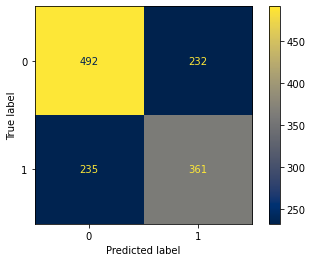

In [29]:
lr_metrics(data_uncorrected)

In [30]:
# print_calib(data_uncorrected)

### Naive Oversampling Metrics

              precision    recall  f1-score   support

           0       0.69      0.64      0.67       724
           1       0.60      0.65      0.62       596

    accuracy                           0.65      1320
   macro avg       0.65      0.65      0.64      1320
weighted avg       0.65      0.65      0.65      1320

AUC score = 0.65


,selection rate (compas)
race,
0,0.508197
1,0.459203


Overall selection rate: 0.49
demographic parity difference: 0.05


,false positive rate,false negative rate
race,,
0,0.343358,0.324873
1,0.372308,0.40099


false positive rate diff: 0.03
false negative rate diff: 0.08
equalized odds diff: 0.08


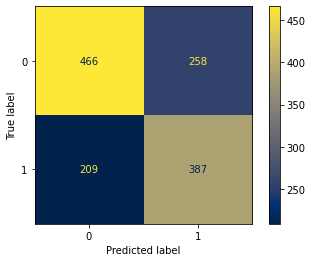

In [31]:
lr_metrics(data_naive_oversampling)

In [32]:
# print_calib(data_naive_oversampling)

### Uniform Sampling Metrics

              precision    recall  f1-score   support

           0       0.67      0.73      0.70       724
           1       0.63      0.56      0.59       596

    accuracy                           0.65      1320
   macro avg       0.65      0.64      0.64      1320
weighted avg       0.65      0.65      0.65      1320

AUC score = 0.64


,selection rate (compas)
race,
0,0.395965
1,0.404175


Overall selection rate: 0.40
demographic parity difference: 0.01


,false positive rate,false negative rate
race,,
0,0.230576,0.436548
1,0.32,0.460396


false positive rate diff: 0.09
false negative rate diff: 0.02
equalized odds diff: 0.09


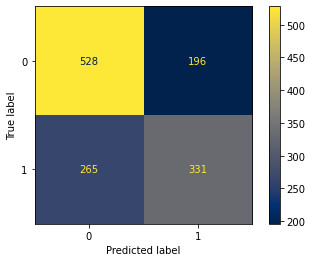

In [33]:
lr_metrics(data_uniform_sampling)

In [34]:
# print_calib(data_uniform_sampling)

### Fair-SMOTE Metrics

              precision    recall  f1-score   support

           0       0.69      0.67      0.68       724
           1       0.61      0.63      0.62       596

    accuracy                           0.65      1320
   macro avg       0.65      0.65      0.65      1320
weighted avg       0.65      0.65      0.65      1320

AUC score = 0.65


,selection rate (compas)
race,
0,0.467844
1,0.455408


Overall selection rate: 0.46
demographic parity difference: 0.01


,false positive rate,false negative rate
race,,
0,0.293233,0.35533
1,0.369231,0.405941


false positive rate diff: 0.08
false negative rate diff: 0.05
equalized odds diff: 0.08


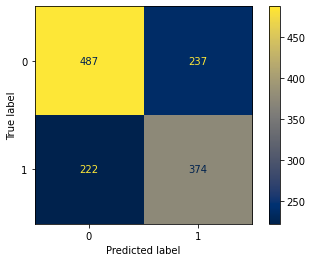

In [35]:
lr_metrics(data_fair_smote)

In [36]:
# print_calib(data_fair_smote)

## Calibration

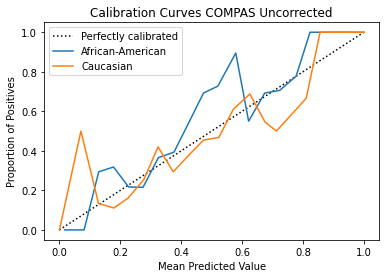

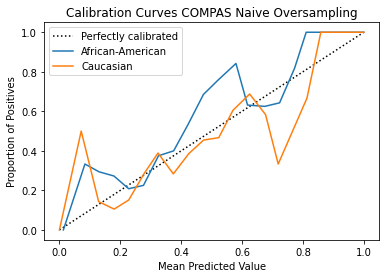

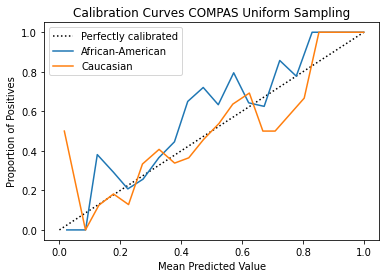

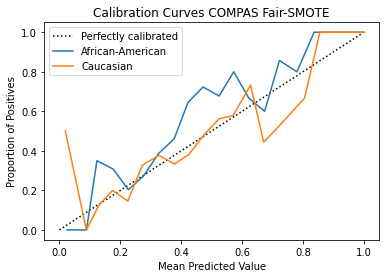

In [37]:
print_calib(data_uncorrected, 'COMPAS Uncorrected')
print_calib(data_naive_oversampling, 'COMPAS Naive Oversampling')
print_calib(data_uniform_sampling, 'COMPAS Uniform Sampling')
print_calib(data_fair_smote, 'COMPAS Fair-SMOTE')